In [1]:
from utils import data_loader, data_table
from skeletons import training_skeleton, autoencoder_skeleton
import glob
import models
import os
import numpy as np

Using TensorFlow backend.


### 1: load and normalize input data
we can use the data_loader for this. 
add an h5 sample, grab the table which represents it, and then split the table into training and testing datasets:

In [2]:
# get h5 datasets
samples = glob.glob("../data/dijet_tight/*.h5")
loader = data_loader("main sample")
for sample in samples:
    loader.add_sample(sample)

data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/dijet_tight/0.0_data.h5'
data_loader :: Grabbing dataset with keys [u'event_feature_data']
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/dijet_tight/7_data.h5'
data_loader :: Grabbing dataset with keys [u'event_feature_data']
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/dijet_tight/8_data.h5'
data_loader :: Grabbing dataset with keys [u'event_feature_data']
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/dijet_tight/6_data.h5'
data_loader :: Grabbing dataset with keys [u'event_feature_data']
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/dijet_tight/5_data.h5'
data_loader :: Grabbing dataset with keys [u

Note that we normalize our training/testing each with respect to the full data sample. 

WE also need to stack the two jets into a single sample - we want jet-based analysis in this case.

In [3]:
data_event = loader.make_table()
print data_event.shape
j1table, j2table = data_event.split_by_column_names("j0*")

j1table = data_table(
    np.asarray(j1table.df),
    headers=list(map(lambda x: x.replace("j0", "jet"), j1table.headers)),
    name="jet1"
)

j2table = data_table(
    np.asarray(j2table.df),
    headers=list(map(lambda x: x.replace("j1", "jet"), j2table.headers)),
    name="jet2"
)

data = data_table(
    data=np.vstack([j1table.df, j2table.df]),
    headers=list(map(lambda x: x.replace("j2", "jet").replace("j1", "jet"), j1table.headers)),
    name="full data"
)
train, test = data.train_test_split(0.4)
train_norm, test_norm = data.norm(train), data.norm(test)
print train_norm.shape, test_norm.shape

data_loader :: Grabbing dataset with keys [u'event_feature_data']
(5618, 14)
(6741, 7) (4495, 7)


#### plotting
we'll also plot the input histograms here, to make sure there are no screaming discrepancies in the training and testing sets

data_table :: plotting distrubution(s) for table(s) ['full data', 'train', 'test']


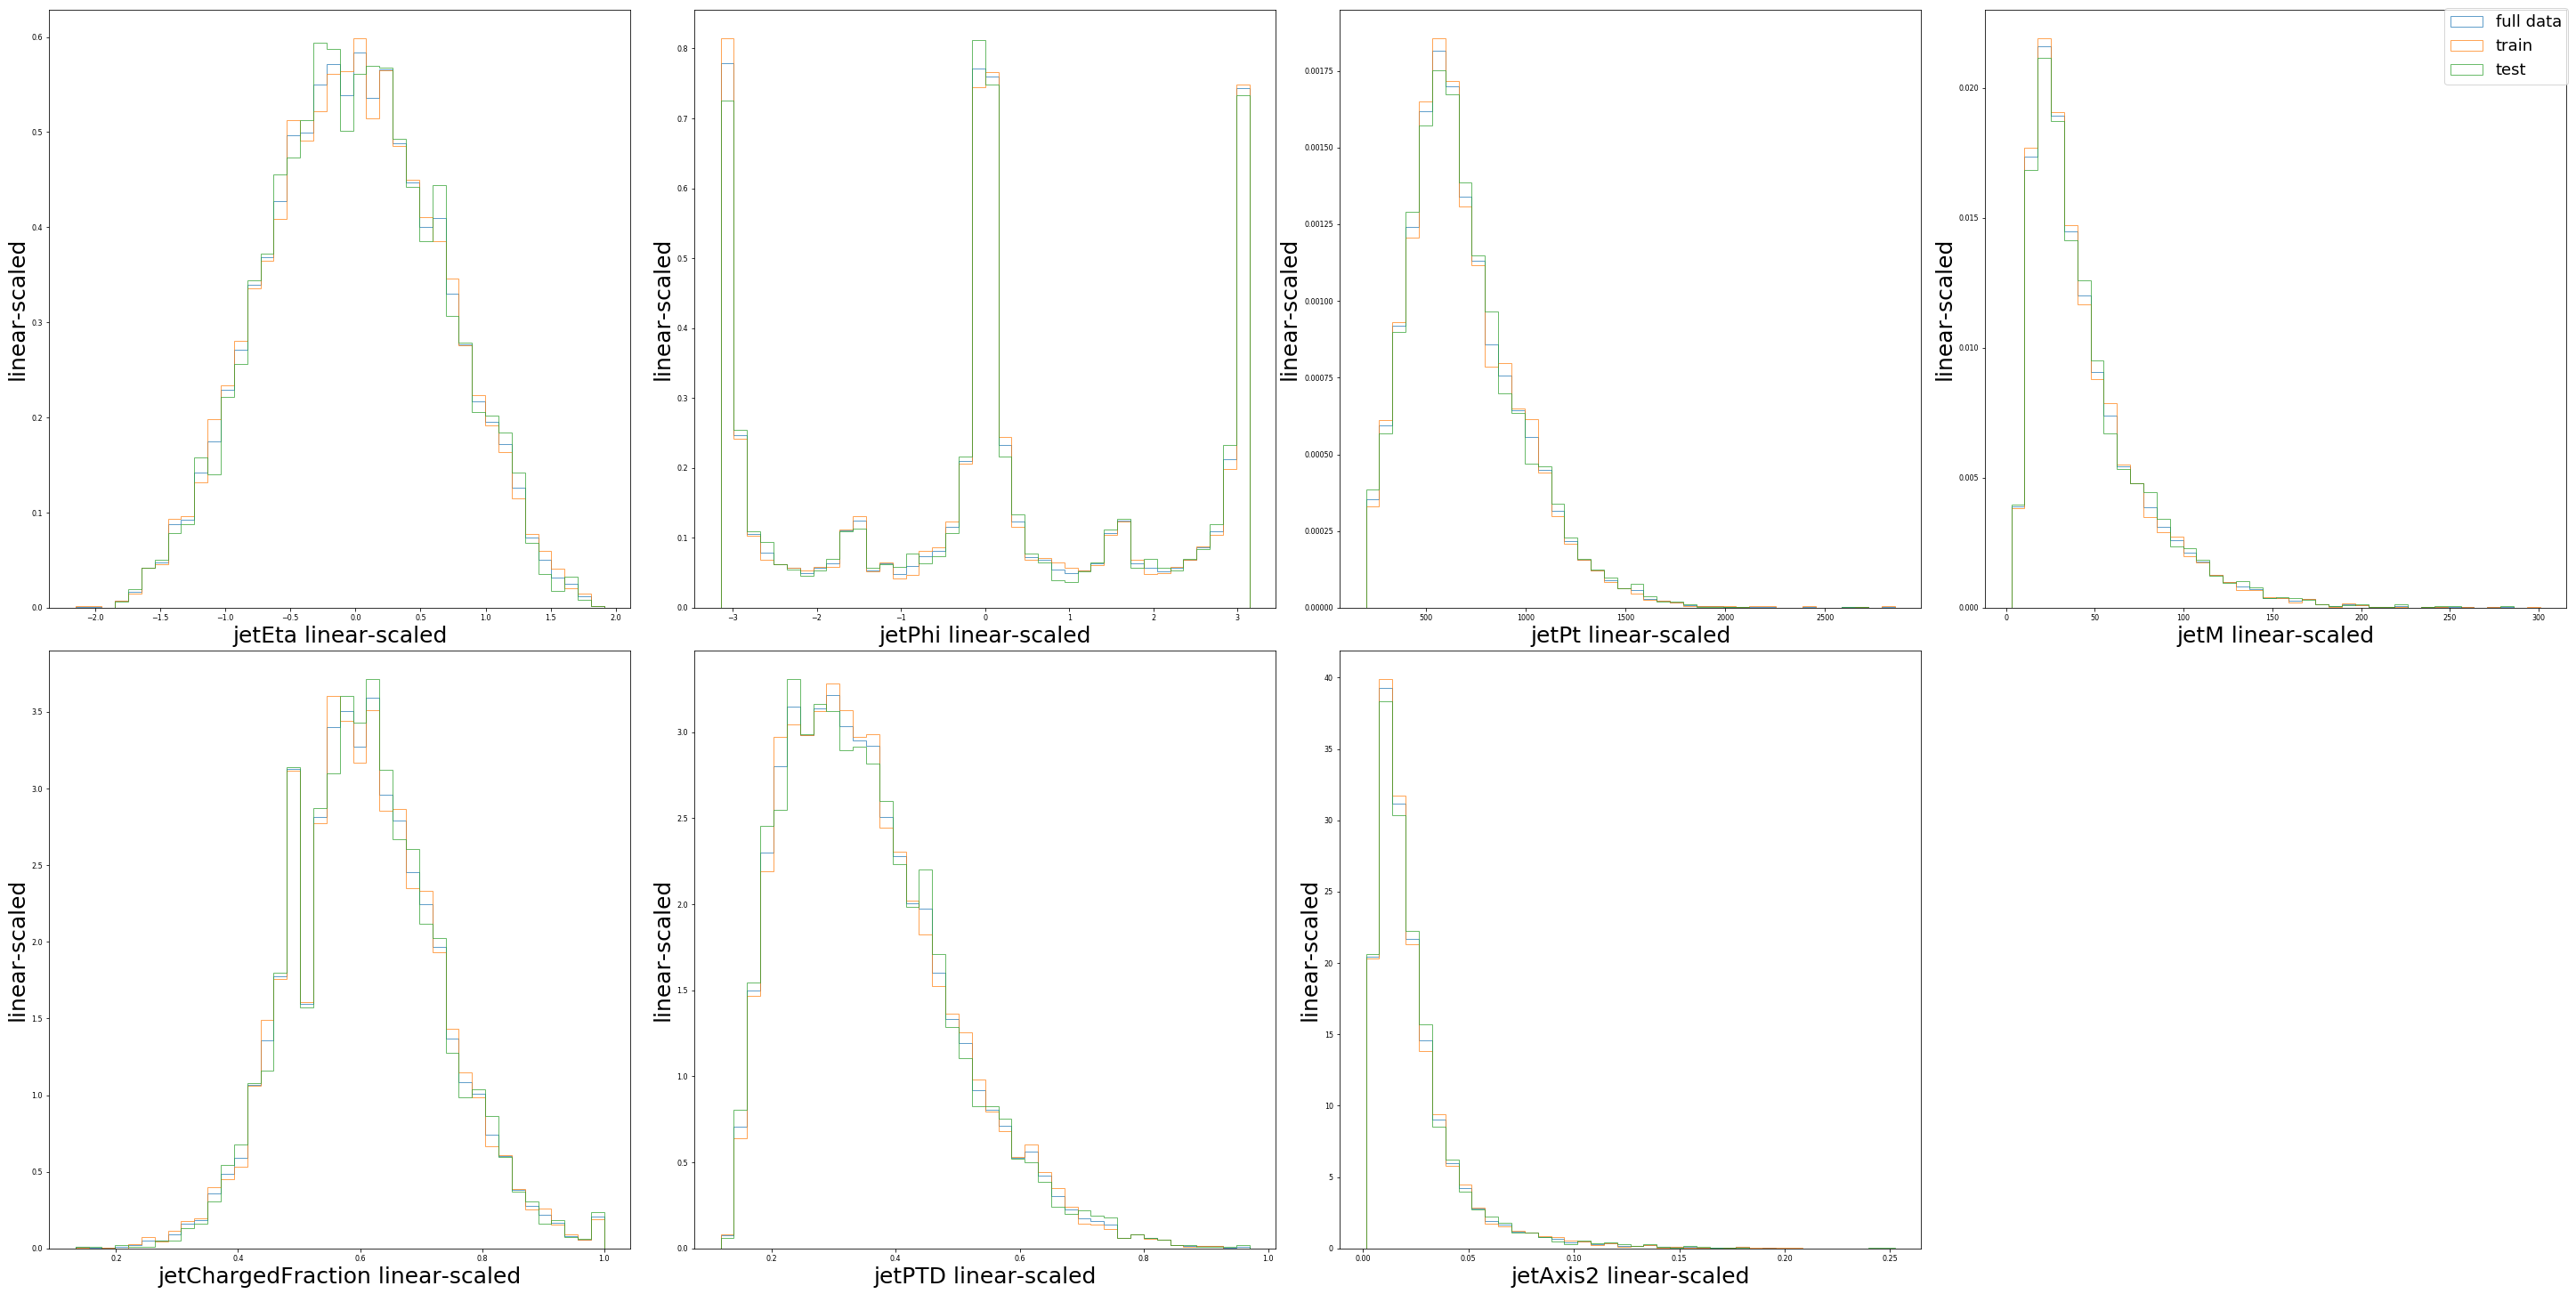

data_table :: plotting distrubution(s) for table(s) ['full data', 'jet1', 'jet2']


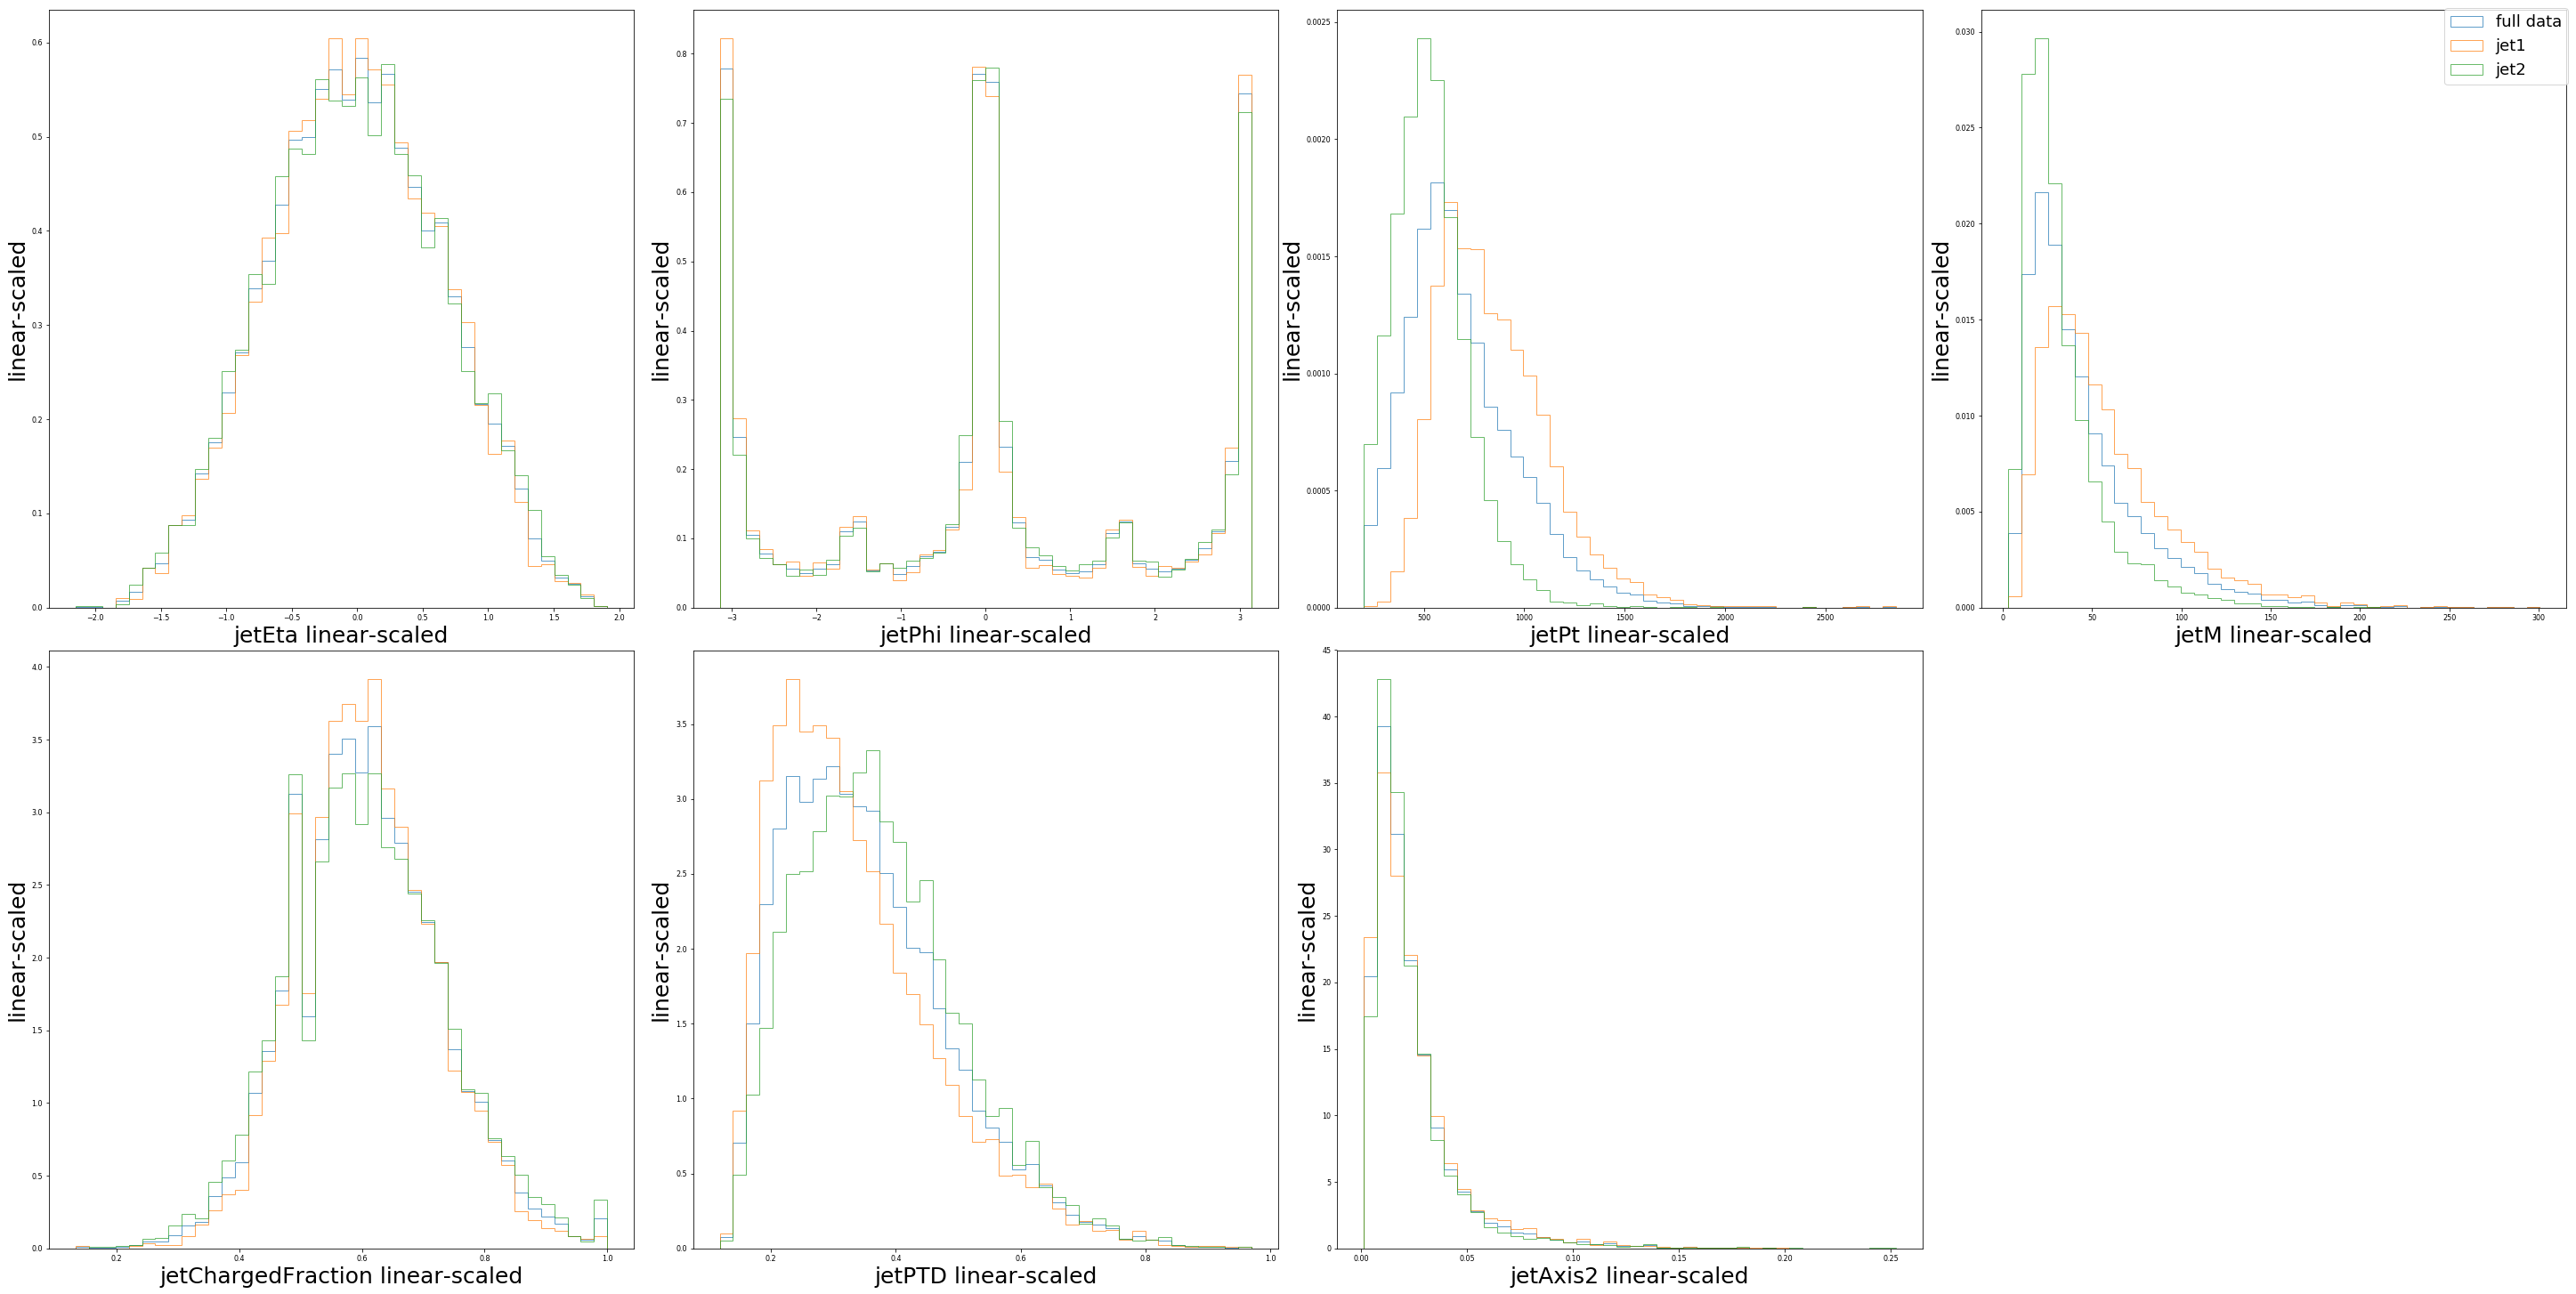

In [4]:
data.plot([train, test], normed=1, bins=40, figsize=(40,20), fontsize=25, cols=4)
data.plot([j1table, j2table], normed=1, bins=40, figsize=(40,20), fontsize=25, cols=4)

### 2. build model 
To make our model, we'll use the simple "shallow" architecture defined in models.py. This gives us a decidedly shallow autoencoder with a bottleneck of our liking.

In [5]:
from keras.regularizers import l1

autoencoder = models.shallow(bn=3, n_features=data.shape[1])
encoder, decoder = autoencoder.layers[1:]
from skeletons import autoencoder_skeleton
s = autoencoder_skeleton()
s.add(7)
s.add(30,'relu')
s.add(4, 'relu')
s.add(30, 'relu')
s.add(7, 'linear')
autoencoder = s.build()
encoder, decoder = autoencoder.layers[1:]

... and the model summaries:

In [6]:
print('encoder summary:')
encoder.summary()
print('\n')
print('decoder summary:')
decoder.summary()
print('\n')
print('autoencoder summary:')
autoencoder.summary()


encoder summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (InputLayer)         (None, 7)                 0         
_________________________________________________________________
layer_2 (Dense)              (None, 30)                240       
_________________________________________________________________
layer_3 (Dense)              (None, 4)                 124       
Total params: 364
Trainable params: 364
Non-trainable params: 0
_________________________________________________________________


decoder summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_3 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
layer_4 (Dense)              (None, 30)                150       
__________________________________________

### 3. train model 
this can be most easily done using the `training_skeleton`, defined in `skeletons.py`. This helps with dynamic training and allows for stopping midway without losing history information, retraining models, etc.

In [7]:
name = "deep_4_test_0"
trainer = training_skeleton(os.path.join("data/training_runs/7jf", name))

train_shell :: locking file '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/data/training_runs/7jf/deep_4_test_0.h5'
h5_elt 'metric_names' :: creating group 'data' in file 'deep_4_test_0.h5'
h5_elt 'metric_names' :: creating dataset 'data/metric_names' in file 'deep_4_test_0.h5'
h5_elt 'training' :: creating group 'params' in file 'deep_4_test_0.h5'
h5_elt 'training' :: creating dataset 'params/training' in file 'deep_4_test_0.h5'
h5_elt 'config' :: creating dataset 'params/config' in file 'deep_4_test_0.h5'


the `training_skeleton` object locks the file it works on while it trains, meaning you cannot have duplicates:

In [8]:
try:
    duplicate = training_skeleton(os.path.join("data/training_runs/7jf", name))
except AttributeError as e:
    print e

train_shell :: ERROR: filename '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/data/training_runs/7jf/deep_4_test_0.h5' is already being edited in another instance!!
filename '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/data/training_runs/7jf/deep_4_test_0.h5' is already being edited in another instance!!
train_shell :: unlocking file 'deep_4_test_0.h5'


training is easy:

In [9]:
from keras import backend as K
import tensorflow as tf


def mse2(y_true, y_pred):
    return K.max(tf.nn.top_k(K.square(y_pred - y_true), k=2).values, axis=-1)

def mse_test(y_true, y_pred):
    l1 = K.square(y_pred[:,0] - y_true[:,0])
    l2 = K.mean(K.square(y_pred[:,1:] - y_true[:,1:]), axis=-1)
    return l1 + l2

def mse_std(y_true, y_pred):
    return K.mean(K.mean(K.square(y_pred - y_true), axis=-1)) + K.mean(K.std(K.square(y_pred - y_true), axis=-2))

def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return ( 1 - SS_res/(SS_tot + K.epsilon()))

autoencoder = trainer.train(
    x_train=train_norm.data,
    x_test=test_norm.data,
    y_train=train_norm.data,
    y_test=test_norm.data,
    optimizer="adam",
    loss='mse',
    epochs=5,
    model=autoencoder,
    metrics=[r_square],
    force=False,
    batch_size=16,
)

train_shell :: TRAINING EPOCH 0/5
Train on 6741 samples, validate on 4495 samples
Epoch 1/1
421/421 [==============================] - 7s 17ms/step - loss: 0.0235 - r_square: 0.6206 - val_loss: 0.0032 - val_r_square: 0.9488
train_shell :: TRAINING EPOCH 1/5
Train on 6741 samples, validate on 4495 samples
Epoch 2/2
421/421 [==============================] - 6s 13ms/step - loss: 0.0029 - r_square: 0.9529 - val_loss: 0.0029 - val_r_square: 0.9539
train_shell :: TRAINING EPOCH 2/5
Train on 6741 samples, validate on 4495 samples
Epoch 3/3
421/421 [==============================] - 5s 12ms/step - loss: 0.0028 - r_square: 0.9553 - val_loss: 0.0027 - val_r_square: 0.9571
train_shell :: TRAINING EPOCH 3/5
Train on 6741 samples, validate on 4495 samples
Epoch 4/4
421/421 [==============================] - 5s 12ms/step - loss: 0.0025 - r_square: 0.9595 - val_loss: 0.0024 - val_r_square: 0.9618
train_shell :: TRAINING EPOCH 4/5
Train on 6741 samples, validate on 4495 samples
Epoch 5/5
421/421 [===

### 4. check results
it is easy to check things like loss, accuracy, etc. later on with this method - all data is saved to an h5 file unique to that training name.

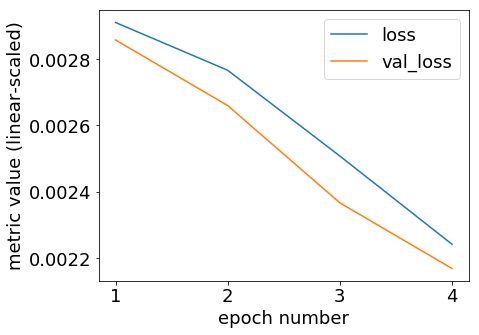

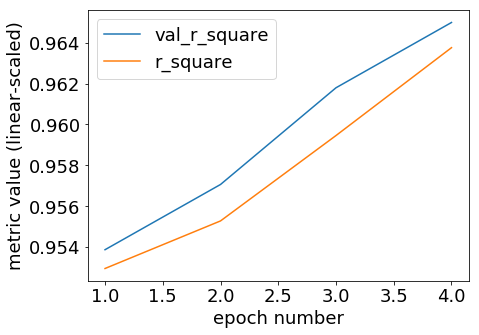

In [10]:
trainer.plot_metrics(fnmatch_criteria="*loss*", yscale="linear")
trainer.plot_metrics(fnmatch_criteria="*r_square*", yscale="linear")

checking results:

data_table :: plotting distrubution(s) for table(s) ['full data', 'pred']


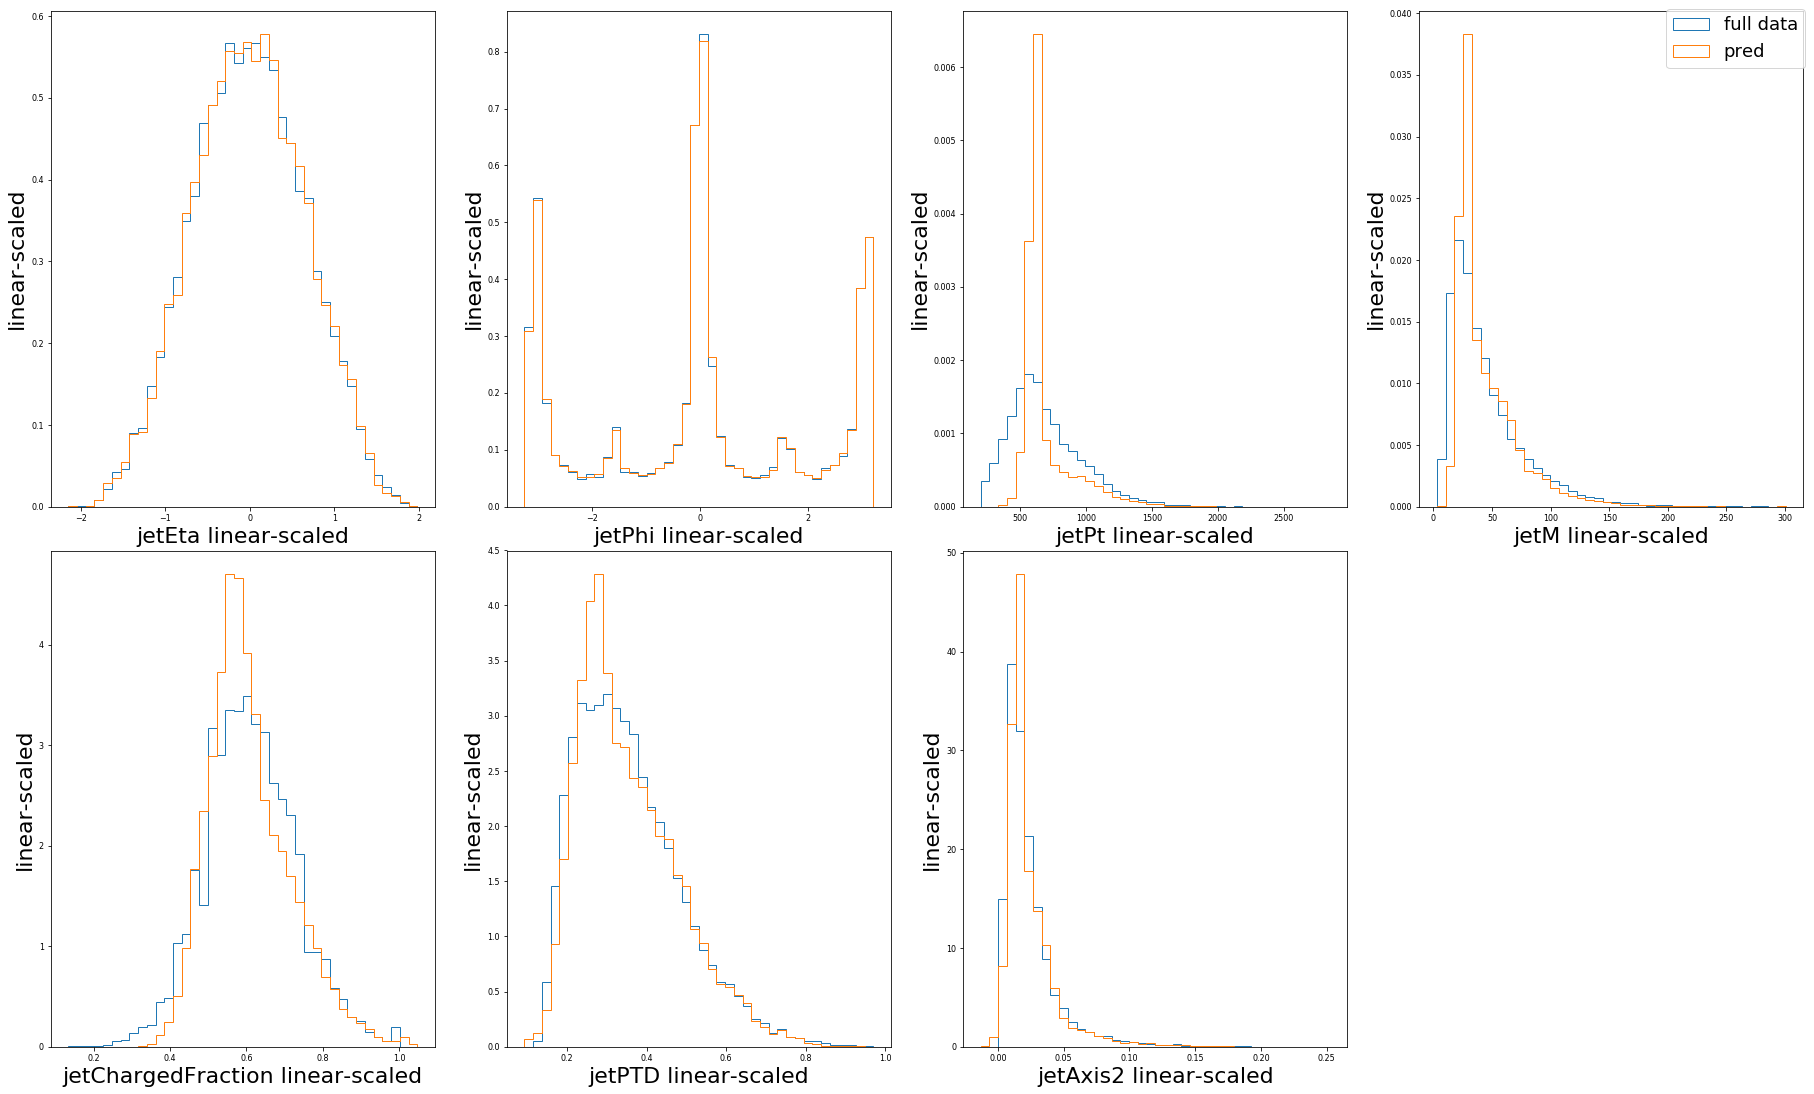

data_table :: plotting distrubution(s) for table(s) ['test reconstructed', 'train reconstructed']


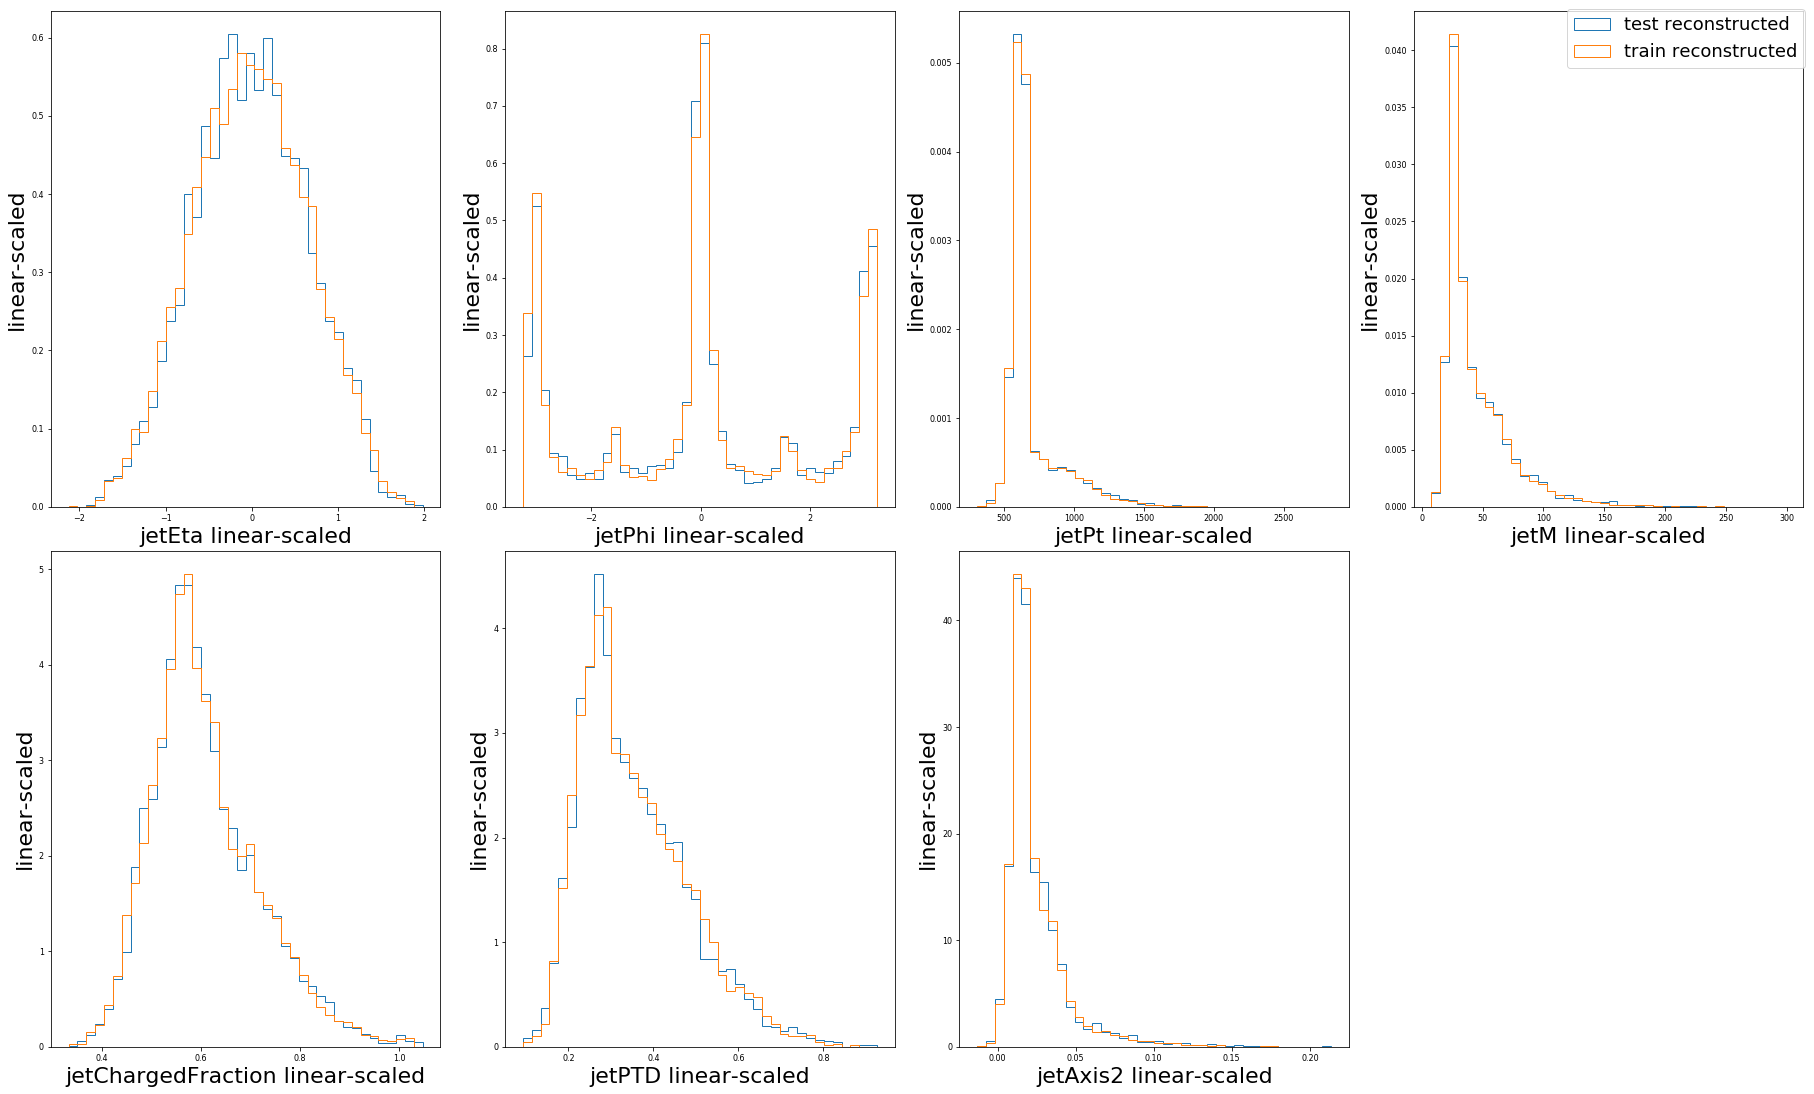

In [11]:
train_reconstructed_norm = data_table(autoencoder.predict(train_norm.data), headers=train_norm.headers)
test_reconstructed_norm = data_table(autoencoder.predict(test_norm.data), headers=test_norm.headers)
full_norm = data_table(autoencoder.predict(data.norm().data), headers=data.headers)

train_reconstructed = data.inorm(train_reconstructed_norm)
test_reconstructed = data.inorm(test_reconstructed_norm)
full = data.inorm(full_norm)

train_reconstructed.name = "train reconstructed"
test_reconstructed.name = "test reconstructed"
full.name = "pred"

# train.plot([train_reconstructed], bins = 30, alpha=1.0)
# test.plot([test_reconstructed], bins=30, alpha=1.0)
data.plot(
    [full],
    normed=1, bins=40, alpha=1.0, figloc="upper right",
    figsize=(25,15), fontsize=22
)
test_reconstructed.plot(
    [train_reconstructed],
    normed=1, bins=40, alpha=1.0, figloc="upper right",
    figsize=(25,15), fontsize=22
)
# test.plot(
#     [test_reconstructed],
#     normed=1, bins=40, alpha=1.0, figloc="upper right",
#     figsize=(25,15), fontsize=22
# )

#### plotting bottleneck representatives

data_table :: plotting distrubution(s) for table(s) ['train_reps', 'test_reps']


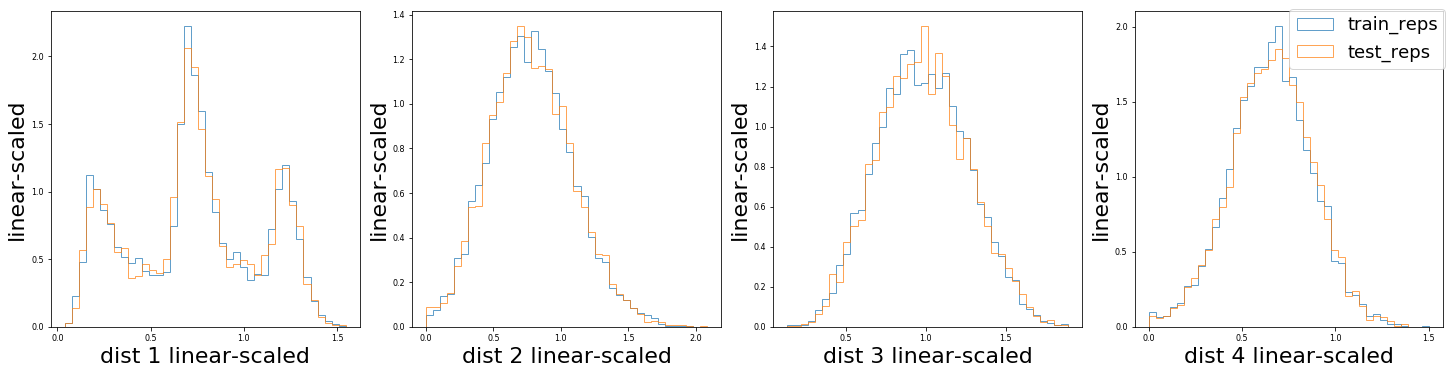

In [13]:
encoder, decoder = autoencoder.layers[1:]
train_reps, test_reps = (
    data_table(encoder.predict(train_norm.data), name="train_reps"),
    data_table(encoder.predict(test_norm.data), name="test_reps")
)
train_reps.plot([test_reps], cols=4, figsize=(20,5), fontsize=22, normed=1, bins=40)